In [111]:
import tensorflow as tf
import math
import numpy as np
import argparse
import os
import sys
import collections
import zipfile
import random
from pathlib import Path
from tensorflow.contrib.tensorboard.plugins import projector
from tempfile import gettempdir
from sklearn import model_selection, linear_model, preprocessing, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline

In [112]:
# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.
# current_path = os.path.dirname(os.path.realpath(sys.argv[0]))
current_path = "/Users/Ganymedian/Desktop/dynamic-rw/output/karate-2nd-p05-q2-nw100/"
start_id = 1
parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

#### Read data

In [113]:
vocab_size = 34
batch_size = 50
embed_size = 5  # Dimension of the embedding vector.
num_sampled = 5  # Number of negative examples to sample.
l_rate = 1.0

In [114]:
def read_data(fname):
    print(fname)
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in rw_location.glob(fname)
        if f.stat().st_size > 0
    ])
    return rws

In [116]:
rw_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/output/karate-stream/")
filename = "gPairs-w3-s6.txt"
# filename = "test.txt"
seed = 1234
np.random.seed(seed=seed)
data = read_data(filename) - start_id
print('Data size', len(data))
# print(data)

gPairs-w3-s6.txt
Data size 40800


In [117]:
data_index = 0
data_size = len(data)
np.random.shuffle(data)
print(data)
batches = np.vsplit(data, data_size/batch_size)
# [print(len(m)) for m in batches]

def generate_batch():
    global data_index
    next_batch = batches[data_index]
    data_index += 1
    targets = next_batch[:,0]
    contexts = next_batch[:,1].reshape(len(next_batch),1)
    return targets, contexts

def end_of_batch():
    if (data_index >= len(batches)):
        return True 
    else:
        return False
    
def reset_batch_gen():
    global data_index
    data_index = 0

[[ 4  5]
 [25 28]
 [10  6]
 ...
 [13 29]
 [26 33]
 [20 33]]


In [118]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 2  # Random set of words to evaluate similarity on.
valid_window = 10  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [119]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_contexts = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
        embeddings = tf.Variable(
              tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
          nce_weights = tf.Variable(
              tf.truncated_normal(
                  [vocab_size, embed_size],
                  stddev=1.0 / math.sqrt(embed_size)))
    with tf.name_scope('biases'):
          nce_biases = tf.Variable(tf.zeros([vocab_size]))
  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_contexts,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocab_size))
    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)
    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(l_rate).minimize(loss)
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()

### Begin Training

In [120]:
num_steps = len(batches)
reset_batch_gen()
with tf.Session(graph=graph) as session:
    # Open a writer to write summaries.
    writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps):
#         print(step)
        inputs, contexts = generate_batch()
        feed_dict = {train_inputs: inputs, train_contexts: contexts}

        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
        # Feed metadata variable to session for visualizing the graph in TensorBoard.
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        average_loss += loss_val

        # Add returned summaries to writer in each step.
        writer.add_summary(summary, step)
        # Add metadata to visualize the graph for the last run.
        if step == (num_steps - 1):
          writer.add_run_metadata(run_metadata, 'step%d' % step)

        if step % 50 == 0:
          if step > 0:
            average_loss /= 50
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step ', step, ': ', average_loss)
          average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
          sim = similarity.eval()
          for i in range(valid_size):
            valid_word = valid_examples[i]
            top_k = 8  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            log_str = 'Nearest to %s:' % valid_word
            for k in range(top_k):
              close_word = nearest[k]
              log_str = '%s %s,' % (log_str, close_word)
            print(log_str)

    final_embeddings = normalized_embeddings.eval()
    # Write corresponding labels for the embeddings.

    with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
        for i in range(vocab_size):
          f.write(str(i+start_id) + '\n')

    # Save the model for checkpoints.
    saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

    # Create a configuration for visualizing embeddings with the labels in TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)

    writer.close()

Initialized
Average loss at step  0 :  6.645024299621582
Nearest to 3: 21, 29, 33, 13, 9, 31, 14, 26,
Nearest to 4: 30, 28, 23, 24, 2, 0, 1, 27,
Average loss at step  50 :  4.621236612796784
Average loss at step  100 :  2.8926857471466065
Average loss at step  150 :  2.500417709350586
Average loss at step  200 :  2.2647382760047914
Average loss at step  250 :  2.131215577125549
Average loss at step  300 :  2.0524452543258667
Average loss at step  350 :  2.106279695034027
Average loss at step  400 :  2.0309212684631346
Average loss at step  450 :  2.09753014087677
Average loss at step  500 :  2.0072055721282958
Average loss at step  550 :  2.039559564590454
Average loss at step  600 :  2.0062662315368653
Average loss at step  650 :  2.0526050829887392
Average loss at step  700 :  2.038424541950226
Average loss at step  750 :  2.007957487106323
Average loss at step  800 :  1.9542180800437927


### Step 6: Visualize the embeddings.

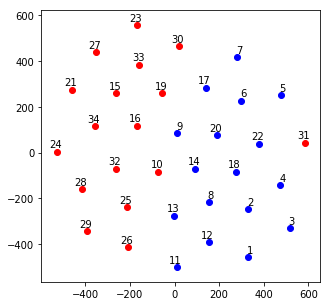

In [121]:
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

tsne_seed = 123

def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
#   plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y, color=node_colors[node_labels[i]-1])
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact', random_state=tsne_seed)
  plot_only = 34
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [(i+start_id) for i in range(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

In [122]:
def read_labels(fname):
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in l_location.glob(fname)
        if f.stat().st_size > 0
    ])

    return (rws[:,0],rws[:,1]) 
l_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/datasets/")
lf_name = "karate-labels.txt"
v_labels = read_labels(lf_name)
nodes = v_labels[0]
node_labels = v_labels[1]
node_colors = ['blue', 'red']

In [123]:
r_seed= 123
def class_train_test(vectors, train_size, test_size):
# Split using sklearn ShuffleSplit
    ss = model_selection.ShuffleSplit(n_splits=1,
                                      train_size=train_size,
                                      test_size=test_size,
                                        random_state = r_seed)
    train_index, test_index = next(ss.split(vectors))

    train_data = vectors[train_index]
    test_data = vectors[test_index]
    train_labels = node_labels[train_index]
    test_labels  = node_labels[test_index]
    # print(train_labels)
    # print(test_labels)

    # Classifier choice
    #classifier = linear_model.LogisticRegression(C=10)
    classifier = svm.SVC(C=1)

    clf = make_pipeline(preprocessing.StandardScaler(), classifier)
    clf.fit(train_data, train_labels)

    train_pred = clf.predict(train_data)
    test_pred = clf.predict(test_data)
    # print(train_pred)
    # print(test_pred)
    train_acc = clf.score(train_data, train_labels)
    test_acc = clf.score(test_data, test_labels)
    train_f1 = f1_score(train_labels, train_pred, average='micro')
    test_f1 = f1_score(test_labels, test_pred, average='micro')
#     print("Train acc:", train_acc)
#     print("Test acc:", test_acc)
#     print("Train f1:", train_f1)
#     print("Test f1:", test_f1)
    return {'train_acc':train_acc, 'test_acc':test_acc, 'train_f1':train_f1, 'test_f1':test_f1}

In [124]:
train_size = 0.3
test_size = 1-train_size
lrs = class_train_test(final_embeddings, train_size, test_size)
print(lrs.get('test_f1'))
print(lrs.get('train_f1'))

0.9583333333333334
1.0
